In [1]:
# Import the 'os' module to work with file system paths and directories.
import os

# Import 'cv2' from OpenCV for computer vision tasks and image processing.
import cv2

# Import 'tensorflow' for deep learning and neural network-based tasks.
import tensorflow as tf

# Import 'numpy' for numerical operations and array handling.
import numpy as np

# Import 'List' from the 'typing' module to specify the type of certain variables.
from typing import List

# Import 'pyplot' from 'matplotlib' for data visualization, particularly plotting graphs and images.
from matplotlib import pyplot as plt

# Import 'imageio' for reading and writing various image file formats.
import imageio


In [2]:
# List the available physical GPUs on the system.
physical_devices = tf.config.list_physical_devices('GPU')

# Attempt to set memory growth for the first available GPU.
try:
      # Enable memory growth for the GPU, which allocates memory on-demand, reducing initial memory consumption.
      tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
      # In case of an exception (e.g., if no GPUs are available or an error occurs), handle it gracefully.
      pass

# This code snippet is used to configure TensorFlow to allocate GPU memory more efficiently.

# - It lists the available physical GPUs on the system using 'tf.config.list_physical_devices'.

# - The 'try' block attempts to set memory growth for the first available GPU using 'tf.config.experimental.set_memory_growth'.

# - Setting 'memory growth' to 'True' allows TensorFlow to allocate GPU memory as needed, which can help avoid
#   allocating all GPU memory upfront and can be beneficial when multiple GPU processes are running concurrently.

# - The 'except' block catches any exceptions that may occur during the memory growth configuration and handles them gracefully.


In [3]:
# Define a function 'load_video' that loads and processes a video file.
def load_video(path: str) -> List[float]:
      # Open the video file using OpenCV's VideoCapture.
      cap = cv2.VideoCapture(path)

      # Initialize an empty list to store video frames.
      frames = []

      # Iterate through all frames in the video.
      for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            # Read the next frame from the video.
            ret, frame = cap.read()

            # Convert the frame to grayscale using TensorFlow.
            frame = tf.image.rgb_to_grayscale(frame)

            # Crop the frame to a specific region of interest (ROI).
            # In this case, it's selecting a portion of the frame from (190, 80) to (236, 220).
            frames.append(frame[190:236, 80:220, :])

      # Release the video capture object to free up resources.
      cap.release()

      # Calculate the mean and standard deviation of the list of frames.
      mean = tf.math.reduce_mean(frames)
      std = tf.math.reduce_std(tf.cast(frames, tf.float32))

      # Standardize the frames by subtracting the mean and dividing by the standard deviation.
      return tf.cast((frames - mean), tf.float32) / std

# This 'load_video' function reads a video file, converts frames to grayscale, crops a region of interest,
# calculates the mean and standard deviation of the frames, and then standardizes the frames.


In [4]:
# Define a list called "vocab" that contains characters for a custom vocabulary.
# This vocabulary includes lowercase English letters, single-quote ('), exclamation mark (!),
# question mark (?), digits from 1 to 9, and space.

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
      vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
      f"The vocabulary is: {char_to_num.get_vocabulary()} "
      f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [6]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [7]:
def load_alignments(path: str) -> List[str]:
      with open(path, 'r') as f:
            lines = f.readlines()
      tokens = []
      for line in lines:
            line = line.split()
            if line[2] != 'sil': 
                  tokens = [*tokens,' ',line[2]]
      return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [8]:
def load_data(path: str): 
      path = bytes.decode(path.numpy())
      #file_name = path.split('/')[-1].split('.')[0]
      # File name splitting for windows
      file_name = path.split('\\')[-1].split('.')[0]
      video_path = os.path.join('data','s1',f'{file_name}.mpg')
      alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
      frames = load_video(video_path) 
      alignments = load_alignments(alignment_path)
      return frames, alignments

In [9]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [10]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [11]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

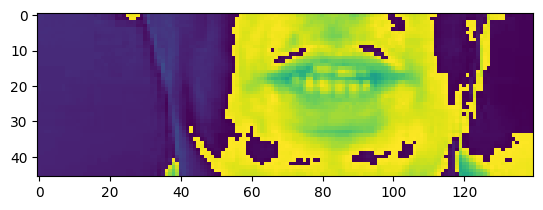

In [12]:
plt.imshow(frames[40])

In [13]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [14]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [15]:
def mappable_function(path:str) ->List[str]:
      result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
      return result

### 3

In [16]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [17]:
len(test)

50

In [18]:
frames, alignments = data.as_numpy_iterator().next()

In [19]:
len(frames)

2

In [20]:
sample = data.as_numpy_iterator()

In [21]:
val = sample.next(); val[0]

array([[[[[1.3479717 ],
          [1.3479717 ],
          [1.310528  ],
          ...,
          [0.        ],
          [0.1872183 ],
          [0.11233097]],

         [[1.3479717 ],
          [1.3479717 ],
          [1.310528  ],
          ...,
          [0.11233097],
          [0.1872183 ],
          [0.22466195]],

         [[1.2730844 ],
          [1.2730844 ],
          [1.2730844 ],
          ...,
          [0.14977463],
          [0.07488731],
          [0.07488731]],

         ...,

         [[0.9360914 ],
          [0.9360914 ],
          [0.9360914 ],
          ...,
          [9.360914  ],
          [9.323471  ],
          [9.323471  ]],

         [[0.8986478 ],
          [0.8986478 ],
          [0.8986478 ],
          ...,
          [9.323471  ],
          [9.323471  ],
          [9.323471  ]],

         [[0.8986478 ],
          [0.8986478 ],
          [0.8986478 ],
          ...,
          [9.323471  ],
          [9.323471  ],
          [9.323471  ]]],


        [[[1.2356

In [22]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.54813289642334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

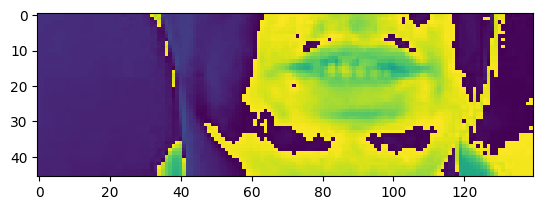

In [23]:
plt.imshow(val[0][0][30])

In [24]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in l six please'>

In [25]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [26]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [27]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [28]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [29]:
yhat = model.predict(val[0])

1/1 [==============================] - 14s 14s/step


In [30]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjjj6666666666666666666666666666666666666666666666666666666666666666666666'>

### 4

In [31]:
def scheduler(epoch, lr):
      if epoch < 30:
            return lr
      else:
          return lr * tf.math.exp(-0.1)

In [32]:
def CTCLoss(y_true, y_pred):
      batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
      input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
      label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

      input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
      label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

      loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
      return loss

In [33]:
class ProduceExample(tf.keras.callbacks.Callback): 
      def __init__(self, dataset) -> None: 
            self.dataset = dataset.as_numpy_iterator()
      def on_epoch_end(self, epoch, logs=None) -> None:
            data = self.dataset.next()
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
            for x in range(len(yhat)):           
                  print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
                  print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                  print('~'*100)

In [34]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [35]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [36]:
schedule_callback = LearningRateScheduler(scheduler)


In [37]:
example_callback = ProduceExample(test)

In [38]:
model.load_weights('models/checkpoint')

In [39]:
test_data = test.as_numpy_iterator()

In [40]:
sample = test_data.next()

In [41]:
yhat = model.predict(sample[0])

1/1 [==============================] - 20s 20s/step


In [42]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green at q nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at h three again'>]

In [43]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [44]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green at q nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at h three again'>]

5

In [45]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bbbm2p.mpg'))

In [46]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by m two please'>]

In [47]:
yhat = model.predict(tf.expand_dims(sample[0],axis=0))

1/1 [==============================] - 4s 4s/step


In [48]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [49]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by m two please'>]